*데이터: AI Hub 의 관광 음식메뉴판 데이터 (OCR용)*

  + *영수증으로 마땅한 데이터가 없어서 유사한 것으로 대체*
  + [AI Hub - 관광 음식메뉴판 데이터](https://aihub.or.kr/aihubdata/data/view.do?currMenu=&topMenu=&aihubDataSe=data&dataSetSn=71553)
    + *해보니까 GT가 메뉴만 되어있던데*

In [1]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


### 1. Settings

In [2]:
import os
import sys

base_dir = "/content/gdrive/MyDrive/Workspace/Colab"
sys.path.append(base_dir)

src_dir = os.path.join(base_dir, "ocr")
%cd $src_dir

/content/gdrive/MyDrive/Workspace/Colab/ocr


In [3]:
!pip install -r requirements.txt > /dev/null

In [5]:
import getpass
from dotenv import load_dotenv

# .env 파일 로드
load_dotenv()

def get_env_variable(var_name, prompt_message) -> str:
    """
    환경 변수 가져오거나,
    없으면 사용자입력
    """
    value = os.getenv(var_name)
    if not value:
        value = getpass.getpass(prompt_message)

    return value

In [6]:
OCR_SECRET_KEY = get_env_variable("OCR_SECRET_KEY", "Enter your OCR_SECRET_KEY: ")
APIGW_URL = get_env_variable("APIGW_INVOKE_URL", "Enter your APIGW_INVOKE_URL: ")

if not OCR_SECRET_KEY:
    raise ValueError("OCR SECRET KEY not found in .env file.")
if not APIGW_URL:
    raise ValueError("APIGW INVOKE URL not found in .env file.")

### 2. 원천/라벨링 데이터 매핑

In [7]:
import import_ipynb
from utils.file_signature_util import FileSignatureUtil



```
dataset_dir/
├── 01.원천데이터/
│   ├── 0.1 서울/
│   │   ├── SL_KF07_M0002_264884_1-tf.jpg
│   │   ├── SL_KF07_M0002_246515_1-tf.jpg
│   │   └── ...
│   └── ...
├── 02.라벨링데이터/
│   ├── 0.1 서울/
│   │   ├── SL_KF07_M0002_264884_1.json
│   │   ├── SL_KF07_M0002_246515_1.json
│   │   └── ...
│   └── ...

```



In [8]:
import glob

src_pattern = "dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/*/SL_*.jpg"
label_pattern = "dataset/AIHub/관광 음식메뉴판 데이터/02.라벨링데이터/*/SL_*.json"

src_files = glob.glob(src_pattern)
label_files = glob.glob(label_pattern)

print("원천 데이터:", src_files[:2])
print("라벨링 데이터:", label_files[:2])

원천 데이터: ['dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_IF02_M0002_36373_1-tf.jpg', 'dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_IF02_M0001_35519_1-tf.jpg']
라벨링 데이터: ['dataset/AIHub/관광 음식메뉴판 데이터/02.라벨링데이터/01. 서울/SL_FF01_M0001_99620_2.json', 'dataset/AIHub/관광 음식메뉴판 데이터/02.라벨링데이터/01. 서울/SL_BF01_M0002_283554_1.json']


In [10]:
def extract_core_name(file_name, is_source=True) -> str:

    base_name = os.path.basename(file_name)
    if is_source:
        # 원천 데이터의 "-tf" 제거
        core_name = base_name.split("-")[0]
    else:
        core_name = os.path.splitext(base_name)[0]

    return core_name


# 매칭 수행 (메뉴판 데이터의 label.json과 image.jpg 매핑)
matched_files = []
for src_file in src_files:

    src_core = extract_core_name(src_file, is_source=True)
    for label_file in label_files:

        label_core = extract_core_name(label_file, is_source=False)
        if src_core == label_core:
            matched_files.append((src_file, label_file))
            break

In [11]:
# 예시
for src, label in matched_files[:2]:
    print(f"원천 데이터: {src}")
    print(f"라벨링 데이터: {label}")
    print("---")

원천 데이터: dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_IF02_M0002_36373_1-tf.jpg
라벨링 데이터: dataset/AIHub/관광 음식메뉴판 데이터/02.라벨링데이터/01. 서울/SL_IF02_M0002_36373_1.json
---
원천 데이터: dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_IF02_M0001_35519_1-tf.jpg
라벨링 데이터: dataset/AIHub/관광 음식메뉴판 데이터/02.라벨링데이터/01. 서울/SL_IF02_M0001_35519_1.json
---


In [12]:
len(matched_files)

269


*sample. label.json*

  + *field['boundingPoly']['vertices'] 보면, 8좌표(좌상단, 우상단, 우하단, 좌하단)*

```
{
  "meta": {
    "file_name": "SL_KF07_M0004_414691_3.jpg",
    "image_original_width": 3024,
    "image_original_height": 4032,
    "captured_date": "",
    "store_id": "414691",
    "store_region": "SL",
    "store_type": "KF07",
    "image_type": "M0004",
    "boundary_coordinates": {
      "box_type": "polygon",
      "points": [
        [
          4.277620566977494,
          6.704445624736481
        ],
        [
          96.39831906477364,
          6.505160814503291
        ],
        [
          92.00448853172794,
          100
        ],
        [
          9.69018236638631,
          100
        ]
      ]
    }
  },
  "annotations": [
    {
      "menu_information": {
        "food_type": "분식/기타",
        "food_subtype": "기타",
        "ko": "통다리치킨까스",
        "en.ROMAN": "tongdari chicken kkaseu",
        "en": "Whole Chicken Cutlet",
        "ja": "丸ごともも肉チキンカツ",
        "zh_CN": "炸整块鸡腿排",
        "zh_TW": "炸雞腿排",
        "price": "8000",
        "ingredients.ko": [
          "닭고기",
          "밀가루",
          "계란"
        ],
        "ingredients.en": [
          "Chicken",
          "Wheat Flour",
          "Eggs"
        ],
        "ingredients.ja": [
          "鶏肉",
          "小麦粉",
          "卵"
        ],
        "ingredients.zh_CN": [
          "鸡肉",
          "面粉",
          "鸡蛋"
        ],
        "ingredients.zh_TW": [
          "雞肉",
          "麵粉",
          "雞蛋"
        ],
        "allergy": [
          "닭고기",
          "밀",
          "계란"
        ],
        "spicy_level": null
      },
      "sn": "SL_KF07_M0004_414691_3-tf_18",
      "ocr": {
        "x": 80.59708605525272,
        "y": 35.54120166167705,
        "text": "통다리치킨까스",
        "width": 9.986772486772528,
        "height": 1.4771902633419307,
        "rotation": 0
      }
    },
```



### 3. OCR 수행

In [13]:
import time
import uuid
import json
import requests
from requests.exceptions import RequestException


def generate_request_message(file_type) -> dict:
    """
    API 요청 message 생성

    :param file_type: 파일 타입
    :return: JSON 형태의 요청 message
    """
    return {
        'version': 'V2',
        'requestId': str(uuid.uuid4()),
        'timestamp': int(round(time.time() * 1000)),
        "lang": "ko",
        'images': [
            {
                'format': file_type,
                'name': 'test'
            }
        ],
        "enableTableDetection": False
    }

In [14]:
def send_multipart_request(secret_key, api_url, image_file, request_message) -> requests.Response:
    """
    멀티파트 형식으로 OCR API 요청
    """
    try:

        image_file_type = image_file.split('.')[-1]

        with open(image_file, 'rb') as f:

            files = {
                'file': (image_file, f, f'application/{image_file_type}')
            }
            data = {
                'message': json.dumps(request_message).encode('UTF-8')
            }
            headers = {
                'X-OCR-SECRET': secret_key
            }

            response = requests.post(api_url, headers=headers, data=data, files=files)

        return response
    except FileNotFoundError:
        return None
    except RequestException as e:
        return None
    except Exception as e:
        return None

*Content-Type*
  + `application/json`
  + `multipart/form-data`

*이미지 세부정보*
  + JSON Array로 작성
  + 호출당 1개의 이미지 Array 작성 가능
  + 이미지 크기: 최대 50 MB
  + 이미지 형식: `jpg`, `jpeg`, `png`, `pdf`, `tif`, `tiff`
    - `pdf`: 최대 10 페이지 인식 가능

In [15]:
def pretty_print_json(byte_data) -> None:
    """
    pretty print
    """
    decoded_data = byte_data.decode('utf-8')
    data = json.loads(decoded_data)

    pretty_json = json.dumps(data, indent=4)
    print(pretty_json)

In [16]:
import cv2
import matplotlib.pyplot as plt
from typing import List

In [17]:
def handle_ocr_response(response, image, label_data) -> None:
    """
    응답 처리
    """
    ocr_result = json.loads(response.text.encode('utf8'))

    all_texts = []
    annotations = []
    highlighted_image = image.copy()

    # OCR 이미지 결과 처리
    for image_result in ocr_result['images']:

        for field in image_result['fields']:
            text = field['inferText']
            confidence = field.get('inferConfidence', 'N/A')
            bounding_box = field['boundingPoly']['vertices']

            all_texts.append(f"Text: {text}, Confidence: {confidence}")
            draw_bounding_box(bounding_box, highlighted_image)

    print("----------------------------------------")
    print("OCR Results:")
    for idx, text in enumerate(all_texts, start=1):
        print(f"{idx}. {text}")

    # GT(ground truth) 라벨 읽기
    with open(label_file, 'r', encoding='utf-8') as f:
        label_data = json.load(f)

    for annotation in label_data['annotations']:
        gt_info = annotation['ocr']
        text = gt_info['text']
        x = gt_info['x']
        y = gt_info['y']
        width = gt_info['width']
        height = gt_info['height']
        gt_bbox = [x, y, width, height]
        draw_bounding_box_gt(gt_bbox, highlighted_image)

    display_results(image, highlighted_image)


def draw_bounding_box(bounding_box, image) -> None:
    """
    BBox
    """
    start_point = (int(bounding_box[0]['x']), int(bounding_box[0]['y']))
    end_point = (int(bounding_box[2]['x']), int(bounding_box[2]['y']))

    cv2.rectangle(image, start_point, end_point, (0, 255, 0), 5)


def draw_bounding_box_gt(bounding_box, image) -> None:
    """
    BBox, 비율을 픽셀로 변환
    해당 메뉴판 데이터는 비율로 되어있음
    """
    image_height, image_width, _ = image.shape

    x_ratio = bounding_box[0]
    y_ratio = bounding_box[1]
    width_ratio = bounding_box[2]
    height_ratio = bounding_box[3]

    x_pixel = int(x_ratio * image_width / 100)
    y_pixel = int(y_ratio * image_height / 100)
    width_pixel = int(width_ratio * image_width / 100)
    height_pixel = int(height_ratio * image_height / 100)

    start_point = (x_pixel, y_pixel)
    end_point = (x_pixel + width_pixel, y_pixel + height_pixel)

    cv2.rectangle(image, start_point, end_point, (0, 0, 255), 5)


def display_results(image, highlighted_image) -> None:
    """
    OCR 결과, 원본 이미지 출력
    OCR 인식 결과 텍스트와 highlighed bbox 까지 출력
    """
    fig, axs = plt.subplots(1, 2, figsize=(15, 10))
    axs[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axs[0].set_title('Original Image')
    axs[0].axis('off')

    axs[1].imshow(cv2.cvtColor(highlighted_image, cv2.COLOR_BGR2RGB))
    axs[1].set_title('Highlighted Image')
    axs[1].axis('off')

    plt.show()

In [19]:
def perform_ocr(image_file, file_type) -> any:
    """
    OCR 요청 수행
    """
    request_message = generate_request_message(file_type)
    return send_multipart_request(OCR_SECRET_KEY, APIGW_URL, image_file, request_message)

File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF05_M0002_146829_3-tf.jpg is a valid jpg file.
----------------------------------------
OCR Results:
1. Text: 보리숭어, Confidence: 0.997
2. Text: 세트, Confidence: 1.0
3. Text: 보리숭어+광어, Confidence: 0.9987
4. Text: AF, Confidence: 0.6906
5. Text: 25,000, Confidence: 0.984
6. Text: 보리숭어, Confidence: 0.9988
7. Text: + 연 어, Confidence: 0.9197
8. Text: 중35,000, Confidence: 0.9576
9. Text: 대, Confidence: 0.9999
10. Text: 45,000, Confidence: 0.9906
11. Text: 보리숭어, Confidence: 0.9998
12. Text: +, Confidence: 0.9999
13. Text: 도다리, Confidence: 1.0
14. Text: (세꼬시), Confidence: 0.9997
15. Text: 특55,000, Confidence: 0.9697


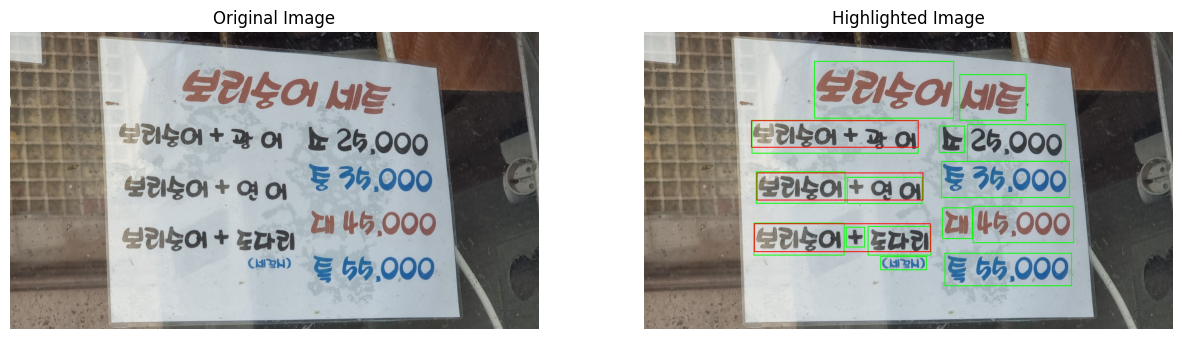

In [20]:
# 파일별
for image_file, label_file in matched_files:

    if "SL_KF05_M0002_146829_3-tf.jpg" not in image_file:
        continue

    try:
        # 파일 읽기
        image = cv2.imread(image_file)
        if image is None:
            continue

        # 매직 넘버 검증
        file_type = FileSignatureUtil.get_file_type(image_file)
        if not file_type:
            continue
        print(f"File {image_file} is a valid {file_type} file.")

        # OCR 수행
        response = perform_ocr(image_file, file_type)

        if response.status_code == 200:
            # print(pretty_print_json(response.text.encode('utf8')))
            handle_ocr_response(response, image, label_file)
        else:
            print(response.status_code)
            print(response.text)
            continue
    except ValueError as e:
        print(e)

*응답 Body*

| 필드           | 타입     | 필수 여부 | 설명                                                                 |
|----------------|---------|----------|----------------------------------------------------------------------|
| **version**    | String  | -        | 버전 정보                                        |
| **requestId**  | String  | -        | API 호출 UUID                                                       |
| **timestamp**  | Integer | -        | API 호출 시각                                            |
| **images**     | Array   | -        | `images` 세부 정보  

*images 세부정보*

| 필드                        | 타입        | 필수 여부 | 설명                                                                 |
|----------------------------|------------|----------|----------------------------------------------------------------------|
| **uid**                     | String     | -        | 이미지 UID (API 유효성 검사 및 요청 추적 시 사용)                   |
| **name**                    | String     | -        | 이미지 이름 (이미지 식별 및 응답 결과 확인 시 사용)                |
| **inferResult**             | String     | -        | 이미지 인식 결과 (`SUCCESS`, `FAILURE`, `ERROR`)                   |
| **message**                 | String     | -        | 결과 메시지                                                         |
| **validationResult**        | Object     | -        | 유효성 검사 결과 정보                                               |
| **validationResult.result** | String     | -        | 유효성 검사 결과 코드 (`NO_REQUESTED`, `UNCHECKED`, `ERROR`, `VALID`, `INVALID`) |
| **validationResult.message**| String     | -        | 유효성 검사 결과 세부 메시지 (항상 응답되는 값은 아님)              |
| **convertedImageInfo**      | Object     | -        | 변환 이미지 정보 (형식이 `pdf` 또는 `tiff`일 때)                   |
| **convertedImageInfo.width**| Integer    | -        | 변환 이미지 가로 길이                                               |
| **convertedImageInfo.height**| Integer   | -        | 변환 이미지 세로 길이                                               |
| **convertedImageInfo.pageIndex**| Integer| -        | 변환 이미지 페이지 인덱스                                           |
| **convertedImageInfo.longImage**| Boolean| -        | 변환 이미지 길이 Long 여부 (`true` | `false`)                       |
| **combineResult**           | Object     | -        | 이미지 인식 결과 결합 정보                                          |
| **combineResult.name**      | String     | -        | 이미지 결합 필드 이름                                               |
| **combineResult.text**      | String     | -        | 각 이미지 필드별 출력값 및 고정 텍스트                             |
| **tables**                  | Array      | -        | 테이블 세부 정보                                                     |
| **fields**                  | Array      | -        | 필드 세부 정보                                                       |




### 4. OCR Evaluation

+ *IoU*
+ *WEM (Word based Exactly Matching)*
+ *1-NED (Normalized Edit Distance)*
+ *Character Error Rate (CER)*
+ *Word Error Rate (WER)*

In [21]:
def IoU(box1, box2) -> float:
    """
    Calculate IoU

    :param box1: [x1, y1, x2, y2]
    :param box2: [x1, y1, x2, y2]
    :return: IoU value
    """
    # 각 좌표 추출
    x1_min, y1_min, x1_max, y1_max = box1
    x2_min, y2_min, x2_max, y2_max = box2

    # 교차 부분, 좌표 계산
    x_inter_min = max(x1_min, x2_min)
    y_inter_min = max(y1_min, y2_min)
    x_inter_max = min(x1_max, x2_max)
    y_inter_max = min(y1_max, y2_max)

    # 교차 영역, 넓이 계산
    inter_width = max(0, x_inter_max - x_inter_min)
    inter_height = max(0, y_inter_max - y_inter_min)
    intersection_area = inter_width * inter_height

    # 각각의 박스 넓이 계산
    box1_area = (x1_max - x1_min) * (y1_max - y1_min)
    box2_area = (x2_max - x2_min) * (y2_max - y2_min)

    # IoU 계산
    iou = intersection_area / (box1_area + box2_area - intersection_area)
    return iou

In [22]:
import nltk
from nltk.tokenize import word_tokenize

nltk.download('punkt_tab')

def WEM(gt_text, pred_text) -> float:
    """
    Calculate WEM

    :param gt_text:
    :param pred_text:
    :return: WEM value
    """
    # tokenize (단어 목록, 중복 제거)
    gt_words = set(word_tokenize(gt_text))
    pred_words = set(word_tokenize(pred_text))

    # 정확히 일치하는 단어들 찾기
    matched_words = gt_words.intersection(pred_words)
    num_matching = len(matched_words)

    # 전체 수
    total_words = len(gt_words)

    wem_score = num_matching / total_words if total_words != 0 else 0
    return wem_score

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


In [23]:
import editdistance

def NED(str1, str2) -> float:
    """
    Calculate NED

    :param str1:
    :param str2:
    :return: 1-NED
    """

    ed = editdistance.eval(str1, str2)
    return 1 - ed / max(len(str1), len(str2))

In [24]:
def CER(gt, pred) -> float:
    return editdistance.eval(gt, pred) / len(gt)

def WER(gt, pred) -> float:
    gt_words = gt.split()
    pred_words = pred.split()
    return editdistance.eval(gt_words, pred_words) / len(gt_words)

In [25]:
def convert_bbox_format(bbox, image) -> list:
    """
    [좌상단, 우하단] 형태로 변환
    해당 데이터셋은 비율로 되어있음
    [x_min, y_min, width, height] to [x_min, y_min, x_max, y_max]
    """
    image_height, image_width, _ = image.shape

    x_ratio = bbox[0]
    y_ratio = bbox[1]
    width_ratio = bbox[2]
    height_ratio = bbox[3]

    x_min = int(x_ratio * image_width / 100)
    y_min = int(y_ratio * image_height / 100)
    width_pixel = int(width_ratio * image_width / 100)
    height_pixel = int(height_ratio * image_height / 100)

    x_max = x_min + width_pixel
    y_max = y_min + height_pixel

    return [x_min, y_min, x_max, y_max]

In [26]:
def handle_ocr_response_eval(response, image, label_data) -> None:
    """
    응답 처리 및 성능 평가
    """

    gt = []
    pred = []

    # OCR 결과 처리
    ocr_result = json.loads(response.text.encode('utf8'))

    for image_result in ocr_result['images']:
        for field in image_result['fields']:
            text = field['inferText']
            bounding_box = field['boundingPoly']['vertices']
            # 좌상단, 우하단 만 필요 (popEval은 4좌표 모두 필요)
            pred.append({
                "text": text,
                "bbox": [
                    int(bounding_box[0]['x']), int(bounding_box[0]['y']),
                    int(bounding_box[2]['x']), int(bounding_box[2]['y'])
                ]
            })

    # GT(ground truth) 라벨 읽기
    with open(label_file, 'r', encoding='utf-8') as f:
        label_data = json.load(f)

    for annotation in label_data['annotations']:
        gt_info = annotation['ocr']
        text = gt_info['text']
        x = gt_info['x']
        y = gt_info['y']
        width = gt_info['width']
        height = gt_info['height']
        gt_bbox = [x, y, width, height]
        gt.append({
            "text": text,
            "bbox": convert_bbox_format(gt_bbox, image)
        })


    wer_scores = []
    cer_scores = []
    ned_scores = []
    wem_scores = []
    iou_scores = []
    matched_pairs = match_gt_pred(gt, pred)
    if matched_pairs:
        for gt, pred, iou_value in matched_pairs:
            if gt and pred:
                iou_scores.append(IoU(gt['bbox'], pred['bbox']))
                wem_scores.append(WEM(gt['text'], pred['text']))
                ned_scores.append(NED(gt['text'], pred['text']))
                wer_scores.append(WER(gt['text'], pred['text']))
                cer_scores.append(CER(gt['text'], pred['text']))
            else:
                print(f"Invalid gt or pred: gt={gt}, pred={pred}")
                continue
    else:
        print("No valid matched pairs found.")

    result = {
        "WER": sum(wer_scores) / len(wer_scores) if wer_scores else 0,
        "CER": sum(cer_scores) / len(cer_scores) if cer_scores else 0,
        "NED": sum(ned_scores) / len(ned_scores) if ned_scores else 0,
        "WEM": sum(wem_scores) / len(wem_scores) if wem_scores else 0,
        "IoU": sum(iou_scores) / len(iou_scores) if iou_scores else 0
    }

    return result

In [27]:
def match_gt_pred(gt_bboxes, pred_bboxes) -> list:

    matched_pairs = []

    for gt in gt_bboxes:

        best_iou = 0
        best_match = None
        for pred in pred_bboxes:

            iou_value = IoU(gt['bbox'], pred['bbox'])
            if iou_value > best_iou:
                best_iou = iou_value
                best_match = pred

        matched_pairs.append((gt, best_match, best_iou))

    return matched_pairs

In [29]:
import random

total_wer = 0
total_cer = 0
total_ned = 0
total_wem = 0
total_iou = 0

num_images = 0

# 파일별로 OCR 수행 및 평가
random_files = random.sample(matched_files, 100)
for image_file, label_file in random_files:

    try:
        # 파일 읽기
        image = cv2.imread(image_file)
        if image is None:
            continue

        # 매직 넘버 검증
        file_type = FileSignatureUtil.get_file_type(image_file)
        if not file_type:
            continue
        print(f"File {image_file} is a valid {file_type} file.")

        # OCR 수행
        response = perform_ocr(image_file, file_type)

        if response.status_code == 200:
            # OCR 응답 처리 후 성능 평가
            result = handle_ocr_response_eval(response, image, label_file)

            total_wer += result["WER"]
            total_cer += result["CER"]
            total_ned += result["NED"]
            total_wem += result["WEM"]
            total_iou += result["IoU"]

            num_images += 1
        else:
            print(response.status_code)
            print(response.text)
            continue
    except ValueError as e:
        print(e)


if num_images > 0:
    print(f"Average WER: {total_wer / num_images:.4f}")
    print(f"Average CER: {total_cer / num_images:.4f}")
    print(f"Average NED: {total_ned / num_images:.4f}")
    print(f"Average WEM: {total_wem / num_images:.4f}")
    print(f"Average IoU: {total_iou / num_images:.4f}")
else:
    print("No valid images processed.")

File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF06_M0001_191443_5-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF03_M0001_9001264_9-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_FF01_M0004_48786_1-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF02_M0001_429482_5-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF01_M0002_263407_2-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_IF03_M0002_424472_1-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF01_M0002_17005_3-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF01_M0002_116581_1-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF02_M0002_354433_1-tf.jpg is a valid jpg file.
File dataset/AIHub/관광 음식메뉴판 데이터/01.원천데이터/01. 서울/SL_KF07_M0002_114565_2-tf.jpg is

*매핑되는 항목에 대해서만 성능평가를 수행했음*